In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm
import datetime
from tueplots import bundles
from tueplots.constants.color.palettes import rgb
from matplotlib import font_manager
font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
font_manager.findfont("times")

read_path = r'C:\Users\Julia\Documents\Uni\Master\1\Data-Literacy\Data-Literacy\Data\joined_survey_article_standardized_median.csv'
df = pd.read_csv(read_path, delimiter=';', header=0)
df["date"] = pd.to_datetime(df["date"], format="%d.%m.%Y")
df["SPD"] = pd.to_numeric(df["SPD"], errors='coerce')
df["Union"] = pd.to_numeric(df["Union"], errors='coerce')
df["Grüne"] = pd.to_numeric(df["Grüne"], errors='coerce')
df["FDP"] = pd.to_numeric(df["FDP"], errors='coerce')
df["AfD"] = pd.to_numeric(df["AfD"], errors='coerce')
df["Linke"] = pd.to_numeric(df["Linke"], errors='coerce')

In [3]:
# filter data: get highest article values, long time before, short time after
dates_max = df.sort_values('standardized_war_articles').nlargest(10, 'standardized_war_articles')
results = {}
removed = pd.DataFrame(columns=["no effect"], index=["Union", "SPD", "Grüne", "FDP", "AfD", "Linke"])
plot_parties = ["Union", "SPD", "Grüne"]
for party in ["Union", "SPD", "Grüne", "FDP", "AfD", "Linke"]:
    removed.loc[party, "no effect"] = 0
for date in dates_max['date']:
    df_res = pd.DataFrame(columns=["R2 Reg", "MSE Reg", "MSE Pred", "Mean diff"])
    results.update({date: df_res})
    time_after = 4*7 # three weeks
    time_before = 4*7
    date_after = date + datetime.timedelta(days=time_after)
    date_before = date - datetime.timedelta(days=time_before)
    total_df = df[(df["date"] <= date_after) & (df["date"] >= date_before)]
    regression_df = total_df[total_df["date"] <= date]
    pred_df = total_df[total_df["date"] >= date]
    for party in ["Union", "SPD", "Grüne", "FDP", "AfD", "Linke"]:
        regression_df = regression_df[(~regression_df[party].isna())]
        pred_df = pred_df[(~pred_df[party].isna())]
        if regression_df.empty or pred_df.empty:
            continue
        X = regression_df.index.values
        Y = regression_df[party]
        # fit model
        model = sm.OLS(Y, X).fit()
        #print(model.summary())
        r2_reg = model.rsquared
        # get values for regression
        y_reg = model.predict(X)
        mse_reg = rmse(Y, y_reg)
        # get values for prediction
        X_pred = pred_df.index.values
        Y_pred = pred_df[party]
        y_pred = model.predict(X_pred)
        mse_pred = rmse(Y_pred, y_pred)
        # only take obs with effect, count otherwise
        if mse_pred > mse_reg:
            df_res.loc[party, "MSE Reg"] = round(mse_reg, 2)
            df_res.loc[party, "MSE Pred"] = round(mse_pred, 2)
            df_res.loc[party, "R2 Reg"] = round(r2_reg, 3)
            # calculate difference
            real_values = pred_df[party]
            diff = real_values - y_pred
            mean_diff = np.mean(diff)
            df_res.loc[party, "Mean diff"] = round(mean_diff, 2)
        else:
            removed.loc[party, "no effect"] += 1

In [4]:
removed

,no effect
Union,2
SPD,4
Grüne,4
FDP,2
AfD,2
Linke,0


In [5]:
# write tex file
with open("table_regression.tex", "w") as f:
    for date in results:
        f.write(date.strftime("%d.%m.%Y") + "\\\n")
        df_now = results[date]
        f.write(df_now.to_latex(columns=["MSE Reg", "MSE Pred", "Mean diff"]))

C:\Users\Julia\AppData\Local\Temp\ipykernel_13900\4181486502.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df_now.to_latex(columns=["MSE Reg", "MSE Pred", "Mean diff"]))
C:\Users\Julia\AppData\Local\Temp\ipykernel_13900\4181486502.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(df_now.to_latex(columns=["MSE Reg", "MSE Pred", "Mean diff"]))
C:\Users\Julia\AppData\Local\Temp\ipykernel_13900\4181486502.py:6: FutureWarning: In future versions `DataFram

In [6]:
# get prediction interval
def ols_quantile(m, X, q):
  # m: OLS model.
  # X: X matrix.
  # q: Quantile.
  #
  # Set alpha based on q.
  a = q * 2
  if q > 0.5:
    a = 2 * (1 - q)
  predictions = m.get_prediction(X)
  frame = predictions.summary_frame(alpha=a)
  if q > 0.5:
    return frame.obs_ci_upper
  return frame.obs_ci_lower

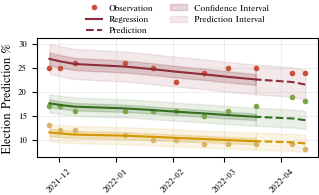

In [24]:
# plot
date = dates_max.iloc[1]['date']
colors = {
    "Union": 'gray',
    "SPD": rgb.tue_ocre,
    "Grüne": rgb.tue_green,
    "Linke": rgb.tue_violet,
    "AfD": rgb.tue_lightblue,
    "FDP": rgb.tue_lightorange
}
colors_reg = {
    "Union": rgb.tue_dark,
    "SPD": rgb.tue_red,
    "Grüne": rgb.tue_darkgreen,
    "Linke": rgb.tue_violet,
    "AfD": rgb.tue_blue,
    "FDP": rgb.tue_orange
}

plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))
fig, ax1 = plt.subplots() 
plt.xticks(rotation=45)
#ax1.set_xlabel('Date') 
ax1.set_ylabel('Election Prediction %')
ax1.grid(color=rgb.tue_gray, alpha = 0.2)
time_after = 4*7 # three weeks
time_before = 16*7
date_after = date + datetime.timedelta(days=time_after)
date_before = date - datetime.timedelta(days=time_before)
total_df = df[(df["date"] <= date_after) & (df["date"] >= date_before)]

regression_df = total_df[total_df["date"] <= date]
pred_df = total_df[total_df["date"] >= date]

legend_labels = [] 
for party in ["SPD", "Grüne", 'FDP']:
    regression_df = regression_df[(~regression_df[party].isna())]
    pred_df = pred_df[(~pred_df[party].isna())]
    if regression_df.empty or pred_df.empty:
        continue
    X = regression_df.index.values
    Y = regression_df[party]
    # fit model
    model = sm.OLS(Y, X).fit()
    # get values for regression
    y_reg = model.predict(X)
    # get values for prediction
    X_pred = pred_df.index.values
    Y_pred = pred_df[party]
    y_pred = model.predict(X_pred)
  
    ax1.plot(total_df['date'], total_df[party], color=colors[party], marker='.', linestyle='', label=f'{party} - Obervation')
    ax1.plot(regression_df['date'], y_reg, color = colors_reg[party], label=f'{party} - Regressionline')
    ax1.plot(pred_df['date'], y_pred, linestyle = '--', color = colors_reg[party], label=f'{party} - Predictionline')
    
   
    # confidence interval
    pred = model.get_prediction(X).summary_frame()
    ax1.fill_between(regression_df['date'], pred['mean_ci_lower'], pred['mean_ci_upper'], color=colors_reg[party], alpha=0.2, label = f'{party} - Confidence Interval')

    # prediction interval
    upper = ols_quantile(model, X_pred, 0.95)
    lower = ols_quantile(model, X_pred, 0.05)
    ax1.fill_between(pred_df['date'], upper, lower, color=colors_reg[party], alpha=0.1, label = f'{party} - Prediction Interval')
    
    # prediction interval
    upper = ols_quantile(model, X, 0.95)
    lower = ols_quantile(model, X, 0.05)
    ax1.fill_between(regression_df['date'], upper, lower, color=colors_reg[party], alpha=0.1)

    if party == "SPD":
        legend_labels.extend(['Observation', 'Regression', 'Prediction', 'Confidence Interval', 'Prediction Interval'])  # Add labels for "Union" party, confidence, and prediction intervals


plt.legend(legend_labels, bbox_to_anchor=(0.85, 1.35), ncol=2, frameon=False)
plt.savefig('Linear Regression_regierung' + '.pdf', format='pdf')
plt.show()

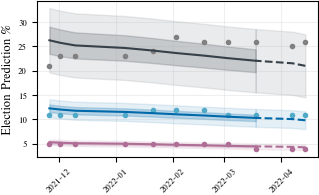

In [25]:
# plot
date = dates_max.iloc[1]['date']
colors = {
    "Union": 'gray',
    "SPD": rgb.tue_ocre,
    "Grüne": rgb.tue_green,
    "Linke": rgb.tue_violet,
    "AfD": rgb.tue_lightblue,
    "FDP": rgb.tue_lightorange
}
colors_reg = {
    "Union": rgb.tue_dark,
    "SPD": rgb.tue_red,
    "Grüne": rgb.tue_darkgreen,
    "Linke": rgb.tue_violet,
    "AfD": rgb.tue_blue,
    "FDP": rgb.tue_orange
}

plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))
fig, ax1 = plt.subplots() 
plt.xticks(rotation=45)
#ax1.set_xlabel('Date') 
ax1.set_ylabel('Election Prediction %')
ax1.grid(color=rgb.tue_gray, alpha = 0.2)
time_after = 4*7 # three weeks
time_before = 16*7
date_after = date + datetime.timedelta(days=time_after)
date_before = date - datetime.timedelta(days=time_before)
total_df = df[(df["date"] <= date_after) & (df["date"] >= date_before)]

regression_df = total_df[total_df["date"] <= date]
pred_df = total_df[total_df["date"] >= date]

legend_labels = [] 
for party in ['Union', 'AfD', 'Linke']:
    regression_df = regression_df[(~regression_df[party].isna())]
    pred_df = pred_df[(~pred_df[party].isna())]
    if regression_df.empty or pred_df.empty:
        continue
    X = regression_df.index.values
    Y = regression_df[party]
    # fit model
    model = sm.OLS(Y, X).fit()
    # get values for regression
    y_reg = model.predict(X)
    # get values for prediction
    X_pred = pred_df.index.values
    Y_pred = pred_df[party]
    y_pred = model.predict(X_pred)
  
    ax1.plot(total_df['date'], total_df[party], color=colors[party], marker='.', linestyle='', label=f'{party} - Obervation')
    ax1.plot(regression_df['date'], y_reg, color = colors_reg[party], label=f'{party} - Regressionline')
    ax1.plot(pred_df['date'], y_pred, linestyle = '--', color = colors_reg[party], label=f'{party} - Predictionline')
    
   
    # confidence interval
    pred = model.get_prediction(X).summary_frame()
    ax1.fill_between(regression_df['date'], pred['mean_ci_lower'], pred['mean_ci_upper'], color=colors_reg[party], alpha=0.2, label = f'{party} - Confidence Interval')

    # prediction interval
    upper = ols_quantile(model, X_pred, 0.95)
    lower = ols_quantile(model, X_pred, 0.05)
    ax1.fill_between(pred_df['date'], upper, lower, color=colors_reg[party], alpha=0.1, label = f'{party} - Prediction Interval')
    
    # prediction interval
    upper = ols_quantile(model, X, 0.95)
    lower = ols_quantile(model, X, 0.05)
    ax1.fill_between(regression_df['date'], upper, lower, color=colors_reg[party], alpha=0.1)

    if party == "Union":
        legend_labels.extend(['Observation', 'Regression', 'Prediction', 'Confidence Interval', 'Prediction Interval'])  # Add labels for "Union" party, confidence, and prediction intervals

#plt.legend(legend_labels, bbox_to_anchor=(0.85, 1.15), ncol=2, frameon=False)
plt.savefig('Linear Regression_Opposition' + '.pdf', format='pdf')
plt.show()